<a href="https://colab.research.google.com/github/Eserhimas/Basics/blob/main/Feedforward_Neural_Networks_Auto_MPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
# Libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Dataset

autompg = tf.keras.utils.get_file( fname='auto-mpg', origin='http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')

40960/30286 [========================================] - 0s 2us/step


In [4]:
column_names = ['mpg', 'cylinders', 'displacement', 'HP',
'weight', 'acceleration', 'modelyear', 'origin']

df = pd.read_csv(autompg, sep=" ", comment='\t', names=column_names, na_values ='?', skipinitialspace=True)

df.head()

,mpg,cylinders,displacement,HP,weight,acceleration,modelyear,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [5]:
df.isna().sum()

mpg             0
cylinders       0
displacement    0
HP              6
weight          0
acceleration    0
modelyear       0
origin          0
dtype: int64

In [6]:
df = df.dropna()

df = df.reset_index(drop=True)

df.isna().sum()

mpg             0
cylinders       0
displacement    0
HP              0
weight          0
acceleration    0
modelyear       0
origin          0
dtype: int64

In [7]:
df.head()

,mpg,cylinders,displacement,HP,weight,acceleration,modelyear,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   HP            392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   modelyear     392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 24.6 KB


In [9]:
def ohe_origin(df):

  df_copy = df.copy()
  df_copy['EU'] = df_copy['origin'].map({1:0,2:1,3:0})
  df_copy['Japan'] = df_copy['origin'].map({1:0,2:0,3:1})
  df_copy = df_copy.drop('origin', axis=1 )
  return df_copy

df_c = ohe_origin(df)

In [10]:
df_c.tail(10)

,mpg,cylinders,displacement,HP,weight,acceleration,modelyear,EU,Japan
382,26.0,4,156.0,92.0,2585.0,14.5,82,0,0
383,22.0,6,232.0,112.0,2835.0,14.7,82,0,0
384,32.0,4,144.0,96.0,2665.0,13.9,82,0,1
385,36.0,4,135.0,84.0,2370.0,13.0,82,0,0
386,27.0,4,151.0,90.0,2950.0,17.3,82,0,0
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0
391,31.0,4,119.0,82.0,2720.0,19.4,82,0,0


In [11]:
train = df_c.sample(frac=0.8, random_state=42)
train_x = train.drop('mpg', axis=1)
train_y = train['mpg']

test = df_c.drop(train.index)
test_x = test.drop('mpg', axis=1)
test_y = test['mpg']

In [12]:
train_stats = train_x.describe().T

In [13]:
train_stats

,count,mean,std,min,25%,50%,75%,max
cylinders,314.0,5.531847,1.729449,3.0,4.000,4.0,8.00,8.0
displacement,314.0,197.855096,106.501896,68.0,105.000,151.0,302.00,455.0
HP,314.0,105.971338,39.636557,46.0,76.000,95.0,130.00,230.0
weight,314.0,3005.745223,859.060925,1649.0,2231.000,2831.5,3641.75,4955.0
acceleration,314.0,15.510828,2.803560,8.0,13.625,15.5,17.00,24.8
modelyear,314.0,75.910828,3.688989,70.0,73.000,76.0,79.00,82.0
EU,314.0,0.171975,0.377961,0.0,0.000,0.0,0.00,1.0
Japan,314.0,0.203822,0.403481,0.0,0.000,0.0,0.00,1.0


In [14]:
def normalizer(x):
  return (x-train_stats['mean'])/train_stats['std']

train_x_sc = normalizer(train_x)
test_x_sc = normalizer(test_x)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

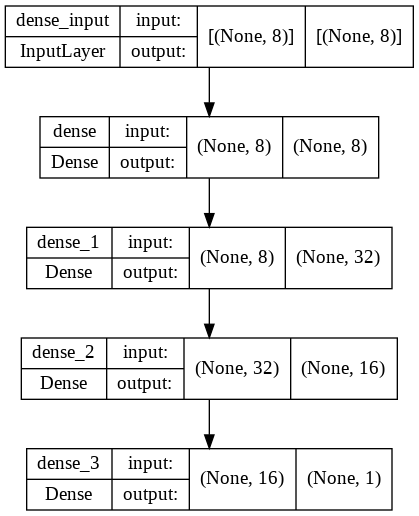

In [16]:
model = Sequential()

model.add(Dense(8, activation=tf.nn.relu, input_shape =[train_x.shape[1]])),
model.add(Dense(32, activation=tf.nn.relu))
model.add(Dense(16, activation=tf.nn.relu))
model.add(Dense(1))

tf.keras.utils.plot_model(model, show_shapes=True)


In [17]:
model.compile(optimizer='Adam', loss ='mse', metrics=['mse','mae'])

In [19]:
# Early stopping

early_stop = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=50)

In [20]:
history = model.fit( x=train_x_sc,
                    y = train_y,
                    epochs=1000,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:609.2711,  mae:23.4136,  mse:609.2711,  val_loss:541.1507,  val_mae:21.9630,  val_mse:541.1507,  
....................................................................................................
Epoch: 100, loss:8.8603,  mae:2.1781,  mse:8.8603,  val_loss:9.1280,  val_mae:2.2452,  val_mse:9.1280,  
....................................................................................................
Epoch: 200, loss:7.4384,  mae:1.9521,  mse:7.4384,  val_loss:7.5700,  val_mae:2.0553,  val_mse:7.5700,  
....................................................................................................
Epoch: 300, loss:6.7981,  mae:1.8598,  mse:6.7981,  val_loss:6.7981,  val_mae:1.9459,  val_mse:6.7981,  
....................................................................................................
Epoch: 400, loss:6.4675,  mae:1.8250,  mse:6.4675,  val_loss:6.5775,  val_mae:1.9029,  val_mse:6.5775,  
..............................................................

In [21]:
plot_obj = tfdocs.plots.HistoryPlotter(smoothing_std=2)

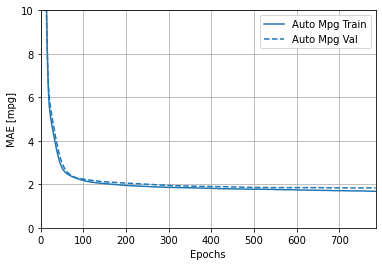

In [25]:
plot_obj.plot({'Auto MPG': history}, metric='mae')
plt.ylim([0,10])
plt.ylabel('MAE [mpg]')
plt.show()

In [26]:
loss, mae, mse = model.evaluate(test_x_sc, test_y, verbose=2)

print(f'Testing set MAE: {mae:5.2f} MPG')

3/3 - 0s - loss: 6.7913 - mse: 6.7913 - mae: 1.9351 - 31ms/epoch - 10ms/step
Testing set MAE:  6.79 MPG


In [27]:
test_pred = model.predict(test_x_sc).flatten()

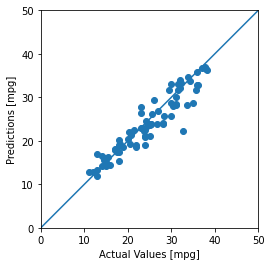

In [28]:
evaluation_plt = plt.axes(aspect='equal')

plt.scatter(test_y, test_pred)
plt.ylabel('Predictions [mpg]')
plt.xlabel('Actual Values [mpg]')
plt.xlim([0,50])
plt.ylim([0,50])
plt.plot([0,50], [0,50])

Text(0, 0.5, 'Count')

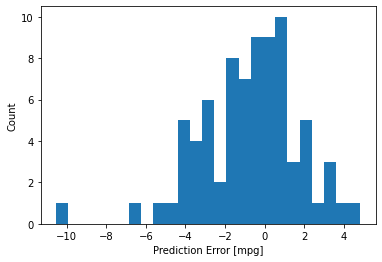

In [29]:
error = test_pred - test_y

plt.hist(error, bins=25)
plt.xlabel("Prediction Error [mpg]")
plt.ylabel("Count")

In [30]:
new_car = pd.DataFrame([[8, 307.0, 130.0, 5504.0, 12.0, 70, 1]], columns=column_names[1:])

In [31]:
new_car

,cylinders,displacement,HP,weight,acceleration,modelyear,origin
0,8,307.0,130.0,5504.0,12.0,70,1


In [32]:
new_car = normalizer(ohe_origin(new_car))
new_car

,cylinders,displacement,HP,weight,acceleration,modelyear,EU,Japan
0,1.427132,1.024817,0.606225,2.908123,-1.252275,-1.60229,-0.455006,-0.505158


In [34]:
new_car_mpg = model.predict(new_car).flatten()
print(f'The prediction miles per gallon value for this car is: {new_car_mpg}')

The prediction miles per gallon value for this car is: [13.691577]
